Personalized Health Recommendation System (Hybrid Version)

This code combines the robustness of dynamic preprocessing with 
the simplicity of clean ML pipeline + model saving. 
It is designed to run without errors if the dataset is properly provided.

In [124]:
# ------------------------------- IMPORTS -----------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

In [126]:
# ------------------------------- CONFIG ------------------------------------
# Update this path if your dataset is in a different location
DATA_PATH = os.path.join('data', 'health.csv')
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [128]:
# ------------------------------- LOAD DATA ---------------------------------
try:
    df = pd.read_csv("C:\\Users\\Muzamil Hussain\\Desktop\\Machine_Learning_project\\health_activity_data.csv")
    print(f"Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "Please place your CSV file in the 'data/' folder or update DATA_PATH."
    )


Dataset loaded successfully: 1000 rows, 16 columns


In [130]:
# ------------------------------- PREPROCESSING -----------------------------
df.columns = [c.strip().lower() for c in df.columns]

# Detect important columns dynamically
def find_col(df_columns, keywords):
    for col in df_columns:
        for kw in keywords:
            if kw in col:
                return col
    return None

col_age = find_col(df.columns, ["age"])
col_height = find_col(df.columns, ["height", "stature"])
col_weight = find_col(df.columns, ["weight", "mass"])
col_sleep = find_col(df.columns, ["sleep"])
col_activity = find_col(df.columns, ["activity", "exercise", "workout"])
col_diet = find_col(df.columns, ["diet", "food", "nutrition"])
col_stress = find_col(df.columns, ["stress"])

# Canonical columns
if col_age: df["age"] = pd.to_numeric(df[col_age], errors="coerce")
if col_height: df["height_cm"] = pd.to_numeric(df[col_height], errors="coerce")
if col_weight: df["weight_kg"] = pd.to_numeric(df[col_weight], errors="coerce")
if col_sleep: df["sleep_hours"] = pd.to_numeric(df[col_sleep], errors="coerce")
if col_activity: df["physical_activity"] = pd.to_numeric(df[col_activity], errors="coerce")
if col_diet: df["diet_quality"] = df[col_diet].astype(str)
if col_stress: df["stress_level"] = pd.to_numeric(df[col_stress], errors="coerce")

In [132]:
# --------------------------- FEATURE ENGINEERING ---------------------------
# BMI
if "height_cm" in df.columns and "weight_kg" in df.columns:
    df["height_m"] = df["height_cm"] / 100.0
    df["bmi"] = df["weight_kg"] / (df["height_m"] ** 2)
    df["bmi"] = df["bmi"].replace([np.inf, -np.inf], np.nan).fillna(df["bmi"].median())

# Diet mapping
if "diet_quality" in df.columns:
    mapping = {"excellent": 1.0, "good": 0.8, "average": 0.5, "poor": 0.2, "very poor": 0.0}
    df["diet_score"] = df["diet_quality"].map(lambda x: mapping.get(str(x).lower().strip(), 0.5))
else:
    df["diet_score"] = 0.5

# Stress normalization (0–1 scale)
if "stress_level" in df.columns:
    df["stress_score"] = (df["stress_level"] - df["stress_level"].min()) / (
        df["stress_level"].max() - df["stress_level"].min() + 1e-9
    )
else:
    df["stress_score"] = 0.5

# Physical activity normalization
if "physical_activity" in df.columns:
    df["activity_score"] = (df["physical_activity"] - df["physical_activity"].min()) / (
        df["physical_activity"].max() - df["physical_activity"].min() + 1e-9
    )
else:
    df["activity_score"] = 0.5

# Health status labels (simple version)
def health_status_from_bmi(bmi):
    if bmi >= 30:
        return "poor"
    elif bmi >= 25:
        return "average"
    else:
        return "good"

df["health_status"] = df["bmi"].apply(health_status_from_bmi)

print("\nHealth status distribution:")
print(df["health_status"].value_counts())


Health status distribution:
health_status
poor       399
good       391
average    210
Name: count, dtype: int64


In [134]:
# ---------------------------- PREPARE DATA ---------------------------------
feature_cols = ["age", "bmi", "sleep_hours", "activity_score", "diet_score", "stress_score"]
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]
y = df["health_status"]


In [136]:
# ---------------------------- TRAIN / TEST SPLIT ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [138]:
#------------------------- HANDLE CLASS IMBALANCE --------------------------
class_counts = y_train.value_counts()
print("\nTraining class distribution before SMOTE:")
print(class_counts)

if class_counts.min() / class_counts.max() < 0.5:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("\nApplied SMOTE. New training distribution:")
    print(pd.Series(y_train_res).value_counts())
else:
    X_train_res, y_train_res = X_train, y_train


Training class distribution before SMOTE:
health_status
poor       319
good       313
average    168
Name: count, dtype: int64


In [140]:
# ------------------------------ SCALING -----------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)



In [142]:
# ------------------------------ MODELING ----------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train_res)



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [144]:
# ------------------------------ EVALUATION --------------------------------
y_pred = rf.predict(X_test_scaled)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

     average       1.00      1.00      1.00        42
        good       1.00      1.00      1.00        78
        poor       1.00      1.00      1.00        80

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
 [[42  0  0]
 [ 0 78  0]
 [ 0  0 80]]


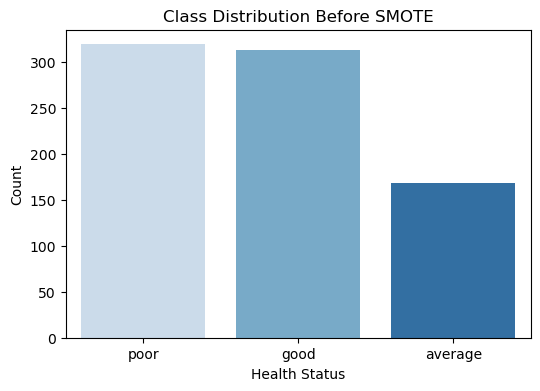

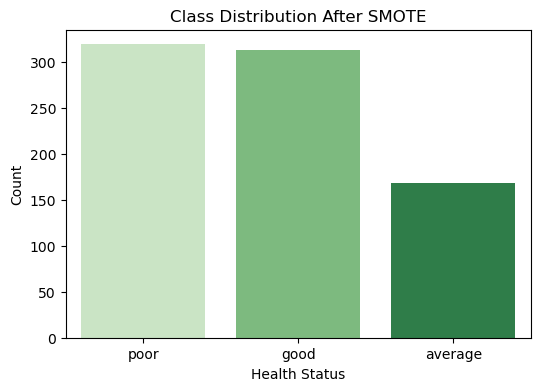

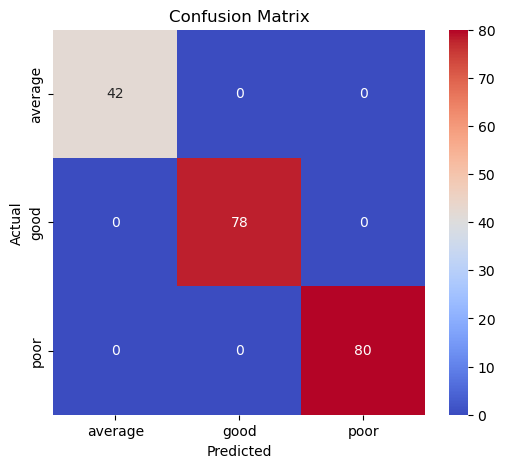

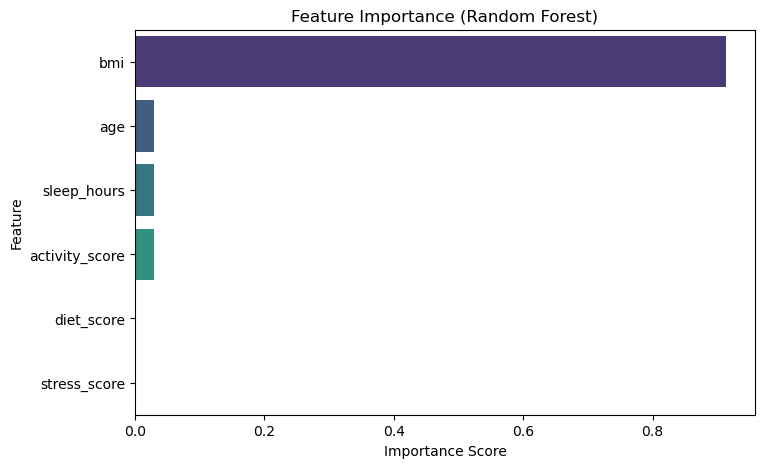

In [146]:
# ----------------------------- VISUALIZATION -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class Distribution Before SMOTE
class_dist_before = pd.DataFrame({
    "Health Status": class_counts.index,
    "Count": class_counts.values
})

plt.figure(figsize=(6, 4))
sns.barplot(data=class_dist_before, x="Health Status", y="Count", hue="Health Status",
            dodge=False, legend=False, palette="Blues")
plt.title("Class Distribution Before SMOTE")
plt.ylabel("Count")
plt.xlabel("Health Status")
plt.show()

# 2. Class Distribution After SMOTE
if 'X_train_res' in locals():
    class_dist_after = pd.DataFrame({
        "Health Status": pd.Series(y_train_res).value_counts().index,
        "Count": pd.Series(y_train_res).value_counts().values
    })
    plt.figure(figsize=(6, 4))
    sns.barplot(data=class_dist_after, x="Health Status", y="Count", hue="Health Status",
                dodge=False, legend=False, palette="Greens")
    plt.title("Class Distribution After SMOTE")
    plt.ylabel("Count")
    plt.xlabel("Health Status")
    plt.show()

# 3. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Feature Importance Plot
importances = rf.feature_importances_
feat_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_importance_df, x="Importance", y="Feature",
            hue="Feature", dodge=False, legend=False, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [148]:
# ---------------------------- SAVE MODEL ----------------------------------
joblib.dump(rf, os.path.join(ARTIFACTS_DIR, "best_rf_model.joblib"))
joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, "scaler.joblib"))
print(f"\nModel and scaler saved in '{ARTIFACTS_DIR}/'")


Model and scaler saved in 'artifacts/'
